Задание **Ultra pro**

Выгрузите какой-нибудь из ваших диалогов любой соц.сети и напишите нейронную сеть для классификации собеседника по сообщению. 

Использование групповых чатов для обучения поощряется, но усложняет задачу. Если необходима конфиденциальность, датасет можно не предоставлять.

Если вы решали эту задачу и для предыдущего занятия, то дополнительно необходимо провести эксперименты по разным сетям, сравнить качество и написать вывод, какой подход показал большую точность: с BOW или с CNN\RNN.

**Ссылка на гугл диск, где лежат файлы-диалог (Обучающие и тестовые)**
https://drive.google.com/drive/folders/1kEOMHDTKK_KbBFttWaubftlO8Qy3EWFB?usp=sharing

**Содержание:**
 - Подключение библиотек
 - Подготовка данных

 - Эксперименты:
        1. BOW
        2. LSTM
        3. Conv1D
        4. LSTM + Conv1D

 - Общая сравнительная таблица       
 - Выводы

***Домашняя работа предоставлена со вложенными разделами, которые для удобства можно свернуть. ***

## Подключение библиотек

In [1]:
import numpy as np
import pandas as pd
import os
from tensorflow.keras import utils
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, Embedding, Flatten
from tensorflow.keras.layers import Conv1D, SpatialDropout1D, MaxPooling1D, GlobalAveragePooling1D, GlobalMaxPooling1D
from tensorflow.keras.layers import LSTM, GRU, SimpleRNN, Bidirectional
from tensorflow.keras.optimizers import RMSprop, Adam
from keras.preprocessing.text import Tokenizer, text_to_word_sequence
from google.colab import files, drive
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
drive.mount('/content/drive')

Mounted at /content/drive


# Подготовка данных

In [3]:
# Создадим функцию для первоначальной обработки файла
def readText(fileName):
  return open(fileName, 'r').read().replace("\n", " ")       # Возвращаем измененный файл

In [4]:
# Объявим классы. Запишем в список
className = ["Юля", "Елена"]
nClasses = len(className)

# Подсчитаем кол-во нужных нам классов
len(className)

2

## Загрузим обучающие тексты

In [5]:
# Создадим 2 пустых списка (обучающий и проверочный), для последующего заполнения

trainText = []
testText = []

In [6]:
# Пройдемся двумя циклами для заполнения списков. Так чтобы каждый i элемент в обучающей выборке соответствовал j элементу в тестовой.

for i in className:                                  # Проходим по каждому классу из списка ["О. Генри", "Стругацкие", "Булгаков", "Саймак", "Фрай", "Брэдберри"
  for j in os.listdir('/content/drive/MyDrive/Диалог/'):                     # Вторым циклом проходим по каждому файлу из папки texts
    if i in j:                                       # Если класс из списка содержится в папке texts, тогда
      if 'Обучающая' in j:                           # Если в имени файла содержится данное слово "Обучающая", то 
        trainText.append(readText('/content/drive/MyDrive/Диалог/' +j))      # Добавить в обучающую выборку
        print (j, 'добавлен в обучающую выборку')    # Проверим добавился или нет
      if 'Тестовая' in j:                            # Если в имени файла содержится данное слово "Тестовая", то 
        testText.append(readText('/content/drive/MyDrive/Диалог/' +j))       # Добавить в тестовую выборку
        print (j, 'добавлен в тестовую выборку')     # Проверим добавился или нет
  print ()                                           # Для разделения до   

(Юля) Тестовая.txt добавлен в тестовую выборку
(Юля ) Обучающая.txt добавлен в обучающую выборку

(Елена) Тестовая.txt добавлен в тестовую выборку
(Елена ) Обучающая.txt добавлен в обучающую выборку



In [7]:
# Посмотрим на результат работы
# Длина списка
print ("Длина списка trainText: ",len(trainText))

# Так же например узнать кол-во символов в одном из обучающих текстов
print ("Количество символов в обучающей выборке: ",len(trainText[1]))
print ("Количество символов в тестовой выборке: ",len(testText[1]))


Длина списка trainText:  2
Количество символов в обучающей выборке:  101631
Количество символов в тестовой выборке:  46689


## Обработка данных. Преобразование в числовые векторы

In [8]:
maxWordsCount = 6700    # Зададим максимальное кол-во слов/индексов при обучении

# C помощью функции Tokenizer разобъем текст и превратим в матрицу числовых значений
tokenizer = Tokenizer(num_words = maxWordsCount, filters = '!"#$%&()*+,-–—./…:;<=>?@[\\]^_`{|}~«»\t\n\xa0\ufeff', lower=True, split=' ', oov_token ='unknow', char_level = False)

tokenizer.fit_on_texts(trainText)     # Обрабатываем методом fit_on_texts подготовленный обучающий список trainText

# Для просмотра нужно вытащить индексы слов c помощью метода word_index.items и сделать из него список
items = list(tokenizer.word_index.items())

In [9]:
# Посмотрим на результат.
# 10 самых часто встречающихся слов:
print (items[:10])

[('unknow', 1), ('и', 2), ('в', 3), ('не', 4), ('а', 5), ('на', 6), ('с', 7), ('у', 8), ('я', 9), ('что', 10)]


In [10]:
# И 10 самых редких слов 
print (items[-10:])

[('полетим', 6692), ('кнопочки', 6693), ('выбираем', 6694), ('аэропорту', 6695), ('понянькаться', 6696), ('экскурсии', 6697), ('поездить', 6698), ('переносят', 6699), ('закладывает', 6700), ('приноровились', 6701)]


In [11]:
# Размер словаря.
len(items)

6701

In [12]:
# Теперь согласно частотному словарю можно преобразовать текст в последовательность индексов

trainWordIndexes = tokenizer.texts_to_sequences(trainText)   # Обучающие в индексы
testWordIndexes = tokenizer.texts_to_sequences(testText)     # Проверочные в индексы

In [13]:
# Посмотрим информацию об этих переменных. Тип и размер.
print (type(trainWordIndexes))   
print (type(testWordIndexes))   
print (len(trainWordIndexes))
print (len(testWordIndexes)) 
# trainWordIndexes и testWordIndexes являются списками (list)

<class 'list'>
<class 'list'>
2
2


In [14]:
# Можно посмотреть как именно преобразовывается текст
print ("В оригинале:                   ", trainText[0][:40])
print ("В последовательности индексов: ", trainWordIndexes[0][:7])

В оригинале:                    А так с ребятами бегает "штабы" строят..
В последовательности индексов:  [5, 17, 7, 1746, 595, 3400, 1747]


## Собирем общую статистику

In [15]:
# Перед подачей в нейронную сеть стоит убедиться что собранная база корректна. Для этого:

symbolsTrainText = 0 # Создадим счетчик для подстчета символов в обучающих текстах
wordsTrainText = 0   # Так же счетчик слов

# Пройдемся циклом по всем классам
print ("Общая статистика по обучающим текстам:\n")

for i in range(nClasses):
    print (className[i], ' '*(10-len(className[i])), len(trainText[i]), "символов и", len(trainWordIndexes[i]), "слов")
    symbolsTrainText += len(trainText[i])       # Общее кол-во символов
    wordsTrainText += len(trainWordIndexes[i])  # Общее кол-во слов

print("\nВ сумме ", symbolsTrainText, "символов и ", wordsTrainText, "слов\n--------------------------------------------")


# Аналогично посмотрим по тестовым

print ("\nОбщая статистика по тестовым текстам:\n")

symbolsTestText = 0 
wordsTestText = 0

for i in range(nClasses):
    print (className[i], ' '*(10-len(className[i])), len(testText[i]), "символов и", len(testWordIndexes[i]), "слов")
    symbolsTestText += len(testText[i])       
    wordsTestText += len(testWordIndexes[i]) 
print("\nВ сумме ", symbolsTestText, "символов и ", wordsTestText, "слов")

Общая статистика по обучающим текстам:

Юля         99961 символов и 16504 слов
Елена       101631 символов и 16842 слов

В сумме  201592 символов и  33346 слов
--------------------------------------------

Общая статистика по тестовым текстам:

Юля         48234 символов и 8127 слов
Елена       46689 символов и 7575 слов

В сумме  94923 символов и  15702 слов


In [16]:
# Видно что с такой базой можно работать. Нет перекоса. Можно приступать к созданию выборок (обучающей и проверочной)

## Создание обучающей и проверочной выборок

In [17]:
# Для начала создадим функции. 
# Первая для разделения на короткие векторы с заданным шагом и размером

def getSetFromIndexes (wordIndexes, xLen, step):     # В качестве аргументов принимает (trainWordIndexes или testWordIndexes - список, размер и шаг) 
  xSample = []                                        # Созадим пустой спискок для хранения векторов
  wordsLen = len(wordIndexes)                         # Кол-во слов в поданных на вход trainWordIndexes или testWordIndexes
  index = 0                                           # Начальный индекс (с помощью этой переменной будем сдвигать шаг)


  while (index + xLen <= wordsLen):                   # Задаем цикл пока не дойдем до конца    
    xSample.append(wordIndexes[index:index + xLen])   # На каждой итерации добавляем в список кусок вектора заданной длины
    index += step                                     # Смещаемся на шаг

  return xSample

In [18]:
# Вторая функция для формирования обучающей и проверочной выборок

def createSetsMultiClasses(wordIndexes, xLen, step):
  nClasses = len(wordIndexes)                            # Зададим кол-во классов выборки
  classesXSample = []                                    # Создадим пустой список в котором будут храниться список нарезанных кусочков предыдущей функцией getSetFromIndexes

  # Пройдемся циклом по каждому тексту выборки из последовательнстей индексов
  for i in wordIndexes:
    classesXSample.append(getSetFromIndexes(i, xLen, step))
  
  # Сформируем один общий список
  xSamples = []                                           # Создаем пустые списки
  ySamples = []

  for t in range(nClasses):                               # В нашем случаи цикл от 0 до 6 (кол-во классов)
    xT = classesXSample[t]                                # На каждой итерации цикла берем очередной нарезанный текст одного из класса

    for i in range (len(xT)):                             # Циклом проходимся по каждому его окну
      xSamples.append(xT[i])                              # Добавляем в общий список обучающей выборке
      ySamples.append(utils.to_categorical(t, nClasses))  # И соответствующий вектор класса
  
  # Переводим в numpy массив
  xSamples = np.array(xSamples)                           
  ySamples = np.array(ySamples)    

  # B возвращаем выборки
  return (xSamples, ySamples)

In [19]:
# Создадим еще одну функцию которая будет распознавать тестовую выборку и выводить результаты
def recognizerMultiClass (model, xTest, modelName):
  print ("Название нейронной сети: ", modelName)        # Для наглядности выведем название сети
  print ()                                              # Пропустим стороку
  totalSumRec = 0                                       # Создадим счетчик суммы правильных ответов

  # Пройдемся циклом по всем классам
  for i in range(nClasses):                             # От 0 до 6 
    currPred = model.predict(xTest[i])                  # Получим результаты распознования класса по блокам слов длинны xLen.
    currOut = np.argmax(currPred, axis=1)               # Определим номер распознанного класса с помощью функции argmax
    evVal = []
    
    for j in range(nClasses):
      evVal.append(len(currOut[currOut==j])/len(xTest[i]))

    totalSumRec +=len(currOut[currOut==i])
    recognizedClass = np.argmax(evVal)                  # Определяем какой класс за какой был распознан в итоге

    # И выводим результаты

    isRecognized = "Ответ НЕВЕРНЫЙ, УВЫ"
    if (recognizedClass == i):
      isRecognized = "УРА, ответ ВЕРНЫЙ!"
    
    str1 = 'Класс: ' + className[i] + " " * (11 - len(className[i])) + str(int(100*evVal[i])) + "% сеть предсказала: " + className[recognizedClass]
    print(str1, " " * (55-len(str1)), isRecognized, sep='')

  # Выведим средний процент распознавания 
  print ()                                                                          # Пустая строка чтобы отделить
  sumCount = 0
  # Пройдемся циклом по всем циклам
  for i in range(nClasses):
    sumCount += len(xTest[i])
  print ("Средний процент распознавания ", int(100*totalSumRec/sumCount), "%")
  print ()                                                                          # Пустая строка чтобы отделить

  return totalSumRec/sumCount

In [20]:
# Функция для распознавания тестовой выборки и вывод результата
def recognizeMultiClass(model, xTest, modelName):

  print("Нейронная сеть: ", modelName)
  print()

  val = []
  pred = []
  totalSumRec = []

  # Циклом прохоим по всем классам
  for i in range(nClasses):
    currPred = model.predict(xTest[i])    # Получение результата распознавания класса по блокам слов длинной xLen
    pred.append(currPred)
    currOut = np.argmax(currPred, axis=1)

    # Подсчет процента распознавания каждого класса

    evVal = []
    sumRec = []

    for j in range(nClasses):
      sumRec.append(0)
      for t in range(len(currOut)):
        if (currOut[t] == j):
          sumRec[j] += 1
      evVal.append(sumRec[j] / len(currOut))

    totalSumRec.append(sumRec[i])

    # Определение какой класс за какой был распознан
    val.append(evVal[i])
    recognizedClass = np.argmax(evVal)

    # Вывод результата распознавания по текущему классу
    isRecognized = "распознано НЕ ВЕРНО!"
    if (recognizedClass == i):
      isRecognized = "распознано ВЕРНО!"
    print(className[i], " распознано ", int(100*evVal[i]), "% сеть считает, что это ", className[recognizedClass], ", ", isRecognized)

  # Вывод среднего процента по всем классам
  print()
  sumVal = 0
  sumCount = 0
  lenXtest = []
    
  for i in range(nClasses):
    sumCount += len(xTest[i])
    sumVal += totalSumRec[i]

  average = int(100*sumVal/sumCount)
  print("Средний процент распознавания ", average, "%")
  return val, average
  

In [21]:
# Создадим функцию которая будет представлять выборку в удобном для распознавания размерах

def createTestMultiClasses(wordIndexes, xLen, step):

  # Создаем тестовую выборку из индексов для каждого из 6 классов
  nClasses = len(wordIndexes)                                             # Переменной nClasses присвоим кол-во классов
  xTest6ClassesBow = []                                                   # Создадим пустой список, в котором будут список из всех классов
  xTest6Classec = []                                                      # Создадим список массивов

  # Пройдемся циклом по каждому тестовому тексту из последовательности индексов
  for i in wordIndexes:
    sample = (getSetFromIndexes(i,xLen, step))                            # Воспользуемся ранее написанной функцией для нарезки на векторы
    xTest6Classec.append(sample)                                          # Добавляем в список на каждой итерации 
    xTest6ClassesBow.append(tokenizer.sequences_to_matrix(sample))        # Трансформируем в BOW
  
  xTest6ClassesBow = np.array(xTest6ClassesBow)                           # Переводим в numpy массив
  xTest6Classec = np.array(xTest6Classec)                                 # Переводим в numpy массив

  return xTest6ClassesBow, xTest6Classec

## Подготовка обучающей и тестовой выборок

In [22]:
# Установим базовые параметры
xLen = 200        # Длина отрезка текста на которые будет разбивать функция getSetFromIndexes
step = 20         # Шаг разбивания для той же функции

In [23]:
# Сформируем выборки (обучающую и тестовую)
xTrain, yTrain = createSetsMultiClasses(trainWordIndexes, xLen, step)
xTest, yTest = createSetsMultiClasses(testWordIndexes, xLen, step)

# Посмотрим что в итоге получилось
print (xTrain.shape)
print (yTrain.shape)
print (xTest.shape)
print (yTest.shape)

(1649, 200)
(1649, 2)
(766, 200)
(766, 2)


Для Embedding обучающие и тестовые наборы готовы, но для BOW нужно xTrain и yTrain представить в виде векторов из 0 и 1

In [24]:
# Преобразовываем в матрицы нулей и единиц по принципу BOW. xTrain и yTrain подаем в виду списка. 
xTrainBOW = tokenizer.sequences_to_matrix(xTrain.tolist())      
xTestBOW = tokenizer.sequences_to_matrix(xTest.tolist())      

# Посмотрим на размер обучающей выборки, сформированной по BOW
print (xTrainBOW.shape)
print (xTestBOW.shape)

#print ("Время обработки:", round(time.time() - cur_time, 2), 'c')

(1649, 6700)
(766, 6700)


In [25]:
# Преобразуем тестовую выборку
xTest6ClassesBow, xTest6Classes = createTestMultiClasses(testWordIndexes, xLen, step)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  app.launch_new_instance()
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


## Функция: вывода summary и схемы нейронной сети и графика обучения

In [26]:
# Функция вывода summary и схемы нейронной сети
def showModel(model):
  #model.summary()
  print ("\n\n")
  return plot_model(model, dpi=80, show_shapes=True)

In [27]:
# Функция вывода графиков
def chart(hist):
  plt.figure(figsize=(10,5))
  plt.plot(hist.history['loss'], label = 'Доля ошибки  на обучающем наборе')
  plt.plot(hist.history['val_loss'], label = 'Доля ошибки на проверочном наборе')
  plt.xlabel('Эпоха обучения')
  plt.ylabel('Доля ошибки')
  plt.legend()
  plt.show()

  plt.figure(figsize=(10,5))
  plt.plot(hist.history['accuracy'], label = 'Доля верных ответов на обучающем наборе')
  plt.plot(hist.history['val_accuracy'], label = 'Доля верных ответов на проверочном наборе')
  plt.xlabel('Эпоха обучения')
  plt.ylabel('Доля верных ответов')
  plt.legend()
  plt.show()

In [28]:
# Функция для сохранения результата обучения. С последующей записью в таблицу pandas. 
def table(hist):
  dct = []  
  # В цикле проходимся по всем значениям из history                                                  
  for i in hist.history.values():                                        
    dct.append(i)                                            # Результат выгружаются в словарь.                                                                
  result = np.array(dct)                                     # Переводим в numpy массив. 
  return result

In [29]:
# Создадим таблицу [Значения maxWordsCount, Число нейроново в слое Dense, Значение в слое Dropout, Активационная функция в первом слое Dense, Кол-во эпох, размер batch_size, Ошибки, Точность ]
df = pd.DataFrame(columns = ['Юля', 'Елена', 'learn_loss(min)', 'learn_accuracy(max)', 'val_loss(min)', 'val_accuracy(max)', 'Средний процент распознавания на проверочной выборке'])

# Эксперименты: 

## 1. Нейронная сеть для BOW

In [42]:
# Создадим полносвязную сеть
model_Bow = Sequential()
model_Bow.add(Dense(300, input_dim=maxWordsCount, activation = 'relu'))  
model_Bow.add(Dropout(0.5))
model_Bow.add(BatchNormalization())
model_Bow.add(Dense(2, activation ='softmax'))

In [43]:
# Скомпилируем ее
model_Bow.compile(optimizer = 'RMSprop', loss='binary_crossentropy', metrics=['accuracy'])

### Обучение

In [44]:
# Обучаем сеть на выборке, xTrainBOW

history_Bow = model_Bow.fit(xTrainBOW, yTrain, epochs=30, batch_size = 50, validation_data=(xTestBOW, yTest))

Epoch 1/30
33/33 [==============================] - 1s 9ms/step - loss: 0.0820 - accuracy: 0.9739 - val_loss: 0.3629 - val_accuracy: 0.8747
Epoch 2/30
33/33 [==============================] - 0s 6ms/step - loss: 0.0028 - accuracy: 1.0000 - val_loss: 0.2747 - val_accuracy: 0.9138
Epoch 3/30
33/33 [==============================] - 0s 6ms/step - loss: 6.8576e-04 - accuracy: 1.0000 - val_loss: 0.2127 - val_accuracy: 0.9256
Epoch 4/30
33/33 [==============================] - 0s 7ms/step - loss: 2.4686e-04 - accuracy: 1.0000 - val_loss: 0.1523 - val_accuracy: 0.9504
Epoch 5/30
33/33 [==============================] - 0s 6ms/step - loss: 5.2326e-05 - accuracy: 1.0000 - val_loss: 0.1962 - val_accuracy: 0.9191
Epoch 6/30
33/33 [==============================] - 0s 6ms/step - loss: 6.6976e-05 - accuracy: 1.0000 - val_loss: 0.0929 - val_accuracy: 0.9634
Epoch 7/30
33/33 [==============================] - 0s 5ms/step - loss: 1.2366e-05 - accuracy: 1.0000 - val_loss: 0.2013 - val_accuracy: 0.9138


### График 








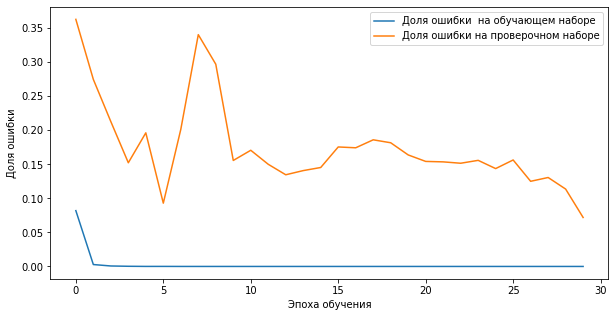

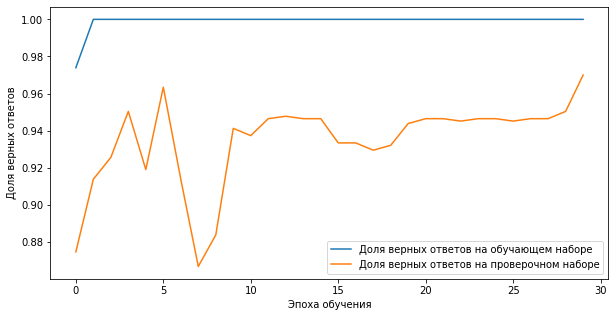

In [45]:
chart(history_Bow)

### Средний процент и таблица

In [54]:
# Посмотрим на результат на тестовой выборке
val_model_Bow, average_model_Bow = recognizeMultiClass(model_Bow, xTest6ClassesBow, "model_Bow")

Нейронная сеть:  model_Bow

Юля  распознано  98 % сеть считает, что это  Юля ,  распознано ВЕРНО!
Елена  распознано  94 % сеть считает, что это  Елена ,  распознано ВЕРНО!

Средний процент распознавания  96 %


In [47]:
# C помощью функции получаем значения на последней эпохе
result_Bow = table(history_Bow)    


In [48]:
val_model_Bow

[0.9899244332493703, 0.948509485094851]

In [52]:
# Заносим результат в таблицу
df.loc['Bow'] = [round(val_model_Bow[0]*100, 2), round(val_model_Bow[1]*100, 2), round(min(result_Bow[0]),4), round(max(result_Bow[1]*100), 2), round(min(result_Bow[2]),2), round(max(result_Bow[3]*100),2), average_model_Bow]

In [53]:
df

,Юля,Елена,learn_loss(min),learn_accuracy(max),val_loss(min),val_accuracy(max),Средний процент распознавания на проверочной выборке
Bow,98.99,94.85,0.0,100.0,0.07,97.0,96.0


## 2. Embedding + LSTM сеть

In [59]:
model_LSTM = Sequential()

model_LSTM.add(Embedding(maxWordsCount, 10, input_length=xLen))

model_LSTM.add(SpatialDropout1D(0.4))

model_LSTM.add(BatchNormalization()) 

model_LSTM.add(LSTM(4, return_sequences=True)) 
model_LSTM.add(Dropout(0.5)) 
model_LSTM.add(BatchNormalization()) 

model_LSTM.add(Dense(100, activation="relu")) 
model_LSTM.add(Dropout(0.5)) 
model_LSTM.add(BatchNormalization()) 

model_LSTM.add(Flatten()) 
model_LSTM.add(Dense(2, activation='softmax'))

In [62]:
model_LSTM.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['accuracy'])

### Обучение

In [63]:
history_model_LSTM = model_LSTM.fit(xTrain, yTrain, epochs=30, batch_size=200, validation_data=(xTest, yTest))

Epoch 1/30
9/9 [==============================] - 3s 77ms/step - loss: 0.0132 - accuracy: 0.9964 - val_loss: 2.1104 - val_accuracy: 0.6854
Epoch 2/30
9/9 [==============================] - 0s 25ms/step - loss: 0.0064 - accuracy: 0.9988 - val_loss: 1.0612 - val_accuracy: 0.7441
Epoch 3/30
9/9 [==============================] - 0s 23ms/step - loss: 0.0134 - accuracy: 0.9970 - val_loss: 0.6046 - val_accuracy: 0.8316
Epoch 4/30
9/9 [==============================] - 0s 27ms/step - loss: 3.8911e-04 - accuracy: 1.0000 - val_loss: 0.6225 - val_accuracy: 0.8277
Epoch 5/30
9/9 [==============================] - 0s 22ms/step - loss: 0.0030 - accuracy: 0.9988 - val_loss: 0.2445 - val_accuracy: 0.9308
Epoch 6/30
9/9 [==============================] - 0s 21ms/step - loss: 0.0126 - accuracy: 0.9970 - val_loss: 0.1665 - val_accuracy: 0.9543
Epoch 7/30
9/9 [==============================] - 0s 22ms/step - loss: 0.0064 - accuracy: 0.9976 - val_loss: 0.1628 - val_accuracy: 0.9530
Epoch 8/30
9/9 [=======

### График 








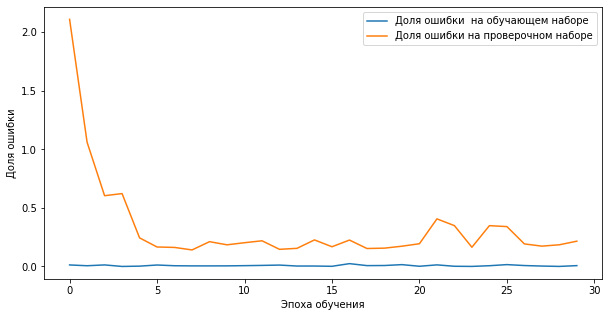

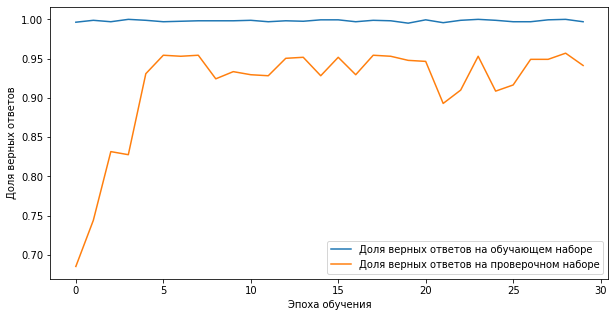

In [64]:
chart(history_model_LSTM)

### Средний процент и таблица

In [65]:
# Посмотрим на результат на тестовой выборке
val_model_LSTM, average_model_LSTM = recognizeMultiClass(model_LSTM, xTest6Classes, "model_LSTM")

Нейронная сеть:  model_LSTM

Юля  распознано  96 % сеть считает, что это  Юля ,  распознано ВЕРНО!
Елена  распознано  91 % сеть считает, что это  Елена ,  распознано ВЕРНО!

Средний процент распознавания  94 %


In [66]:
# C помощью функции получаем значения на последней эпохе
result_LSTM = table(history_model_LSTM)    


In [71]:
# Заносим результат в таблицу
df.loc['LSTM'] = [round(val_model_LSTM[0]*100, 2), round(val_model_LSTM[1]*100, 2), round(min(result_LSTM[0]),4), round(max(result_LSTM[1]*100), 2), round(min(result_LSTM[2]),2), round(max(result_LSTM[3]*100),2), average_model_LSTM]

In [72]:
df

,Юля,Елена,learn_loss(min),learn_accuracy(max),val_loss(min),val_accuracy(max),Средний процент распознавания на проверочной выборке
Bow,98.99,94.85,0.0000,100.0,0.07,97.00,96.0
LSTM,96.73,91.33,0.0004,100.0,0.14,95.69,94.0


## 3.Embedding + Conv1D сеть

In [73]:
model_Conv_1D = Sequential() 

model_Conv_1D.add(Embedding(maxWordsCount, 10, input_length=xLen))

model_Conv_1D.add(SpatialDropout1D(0.2)) 
model_Conv_1D.add(BatchNormalization())  
model_Conv_1D.add(Conv1D(20, 5, activation="relu", padding='same'))  
model_Conv_1D.add(Conv1D(20, 5, activation="relu")) 
model_Conv_1D.add(MaxPooling1D(2))
model_Conv_1D.add(Dropout(0.2)) 
model_Conv_1D.add(BatchNormalization()) 
model_Conv_1D.add(Flatten()) 
model_Conv_1D.add(Dense(2, activation='softmax')) 

In [74]:
model_Conv_1D.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['accuracy'])

### Обучение

In [75]:
history_model_Conv_1D = model_Conv_1D.fit(xTrain, yTrain, epochs=100, batch_size=200, validation_data=(xTest, yTest))

Epoch 1/100
9/9 [==============================] - 28s 90ms/step - loss: 0.8286 - accuracy: 0.5506 - val_loss: 0.6941 - val_accuracy: 0.4817
Epoch 2/100
9/9 [==============================] - 0s 12ms/step - loss: 0.4655 - accuracy: 0.8266 - val_loss: 0.7011 - val_accuracy: 0.4817
Epoch 3/100
9/9 [==============================] - 0s 12ms/step - loss: 0.1887 - accuracy: 0.9654 - val_loss: 0.7038 - val_accuracy: 0.4817
Epoch 4/100
9/9 [==============================] - 0s 11ms/step - loss: 0.0571 - accuracy: 0.9964 - val_loss: 0.7093 - val_accuracy: 0.4817
Epoch 5/100
9/9 [==============================] - 0s 11ms/step - loss: 0.0227 - accuracy: 1.0000 - val_loss: 0.7354 - val_accuracy: 0.4817
Epoch 6/100
9/9 [==============================] - 0s 11ms/step - loss: 0.0127 - accuracy: 0.9994 - val_loss: 0.7505 - val_accuracy: 0.4817
Epoch 7/100
9/9 [==============================] - 0s 11ms/step - loss: 0.0063 - accuracy: 0.9994 - val_loss: 0.7473 - val_accuracy: 0.4817
Epoch 8/100
9/9 [==

### График 








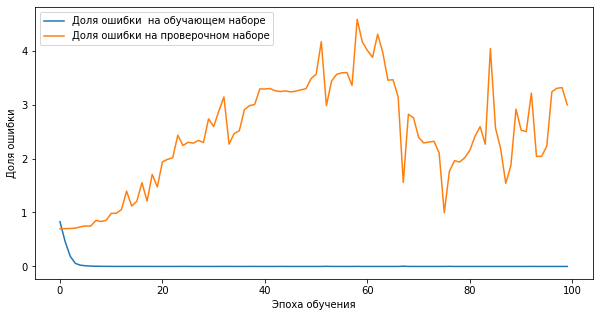

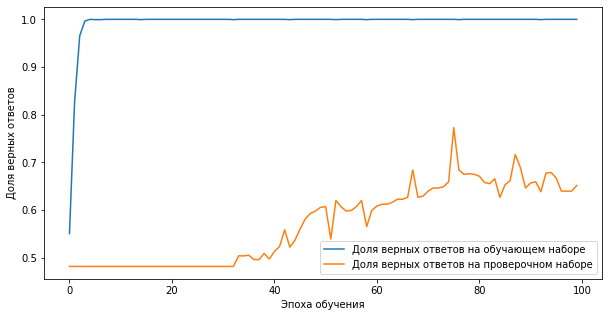

In [77]:
chart(history_model_Conv_1D)

### Средний процент и таблица

In [78]:
# Посмотрим на результат на тестовой выборке
val_model_Conv_1D, average_model_Conv_1D = recognizeMultiClass(model_Conv_1D, xTest6Classes, "model_Conv_1D")

Нейронная сеть:  model_Conv_1D

Юля  распознано  32 % сеть считает, что это  Елена ,  распознано НЕ ВЕРНО!
Елена  распознано  100 % сеть считает, что это  Елена ,  распознано ВЕРНО!

Средний процент распознавания  65 %


In [79]:
# C помощью функции получаем значения на последней эпохе
result_model_Conv_1D = table(history_model_Conv_1D)    

In [80]:
# Заносим результат в таблицу
df.loc['Conv_1D'] = [round(val_model_Conv_1D[0]*100, 2), round(val_model_Conv_1D[1]*100, 2), round(min(result_model_Conv_1D[0]),2), round(max(result_model_Conv_1D[1]*100), 2), round(min(result_model_Conv_1D[2]),2), round(max(result_model_Conv_1D[3]*100),2), average_model_Conv_1D]

In [81]:
df

,Юля,Елена,learn_loss(min),learn_accuracy(max),val_loss(min),val_accuracy(max),Средний процент распознавания на проверочной выборке
Bow,98.99,94.85,0.0000,100.0,0.07,97.00,96.0
LSTM,96.73,91.33,0.0004,100.0,0.14,95.69,94.0
Conv_1D,32.75,100.00,0.0000,100.0,0.69,77.28,65.0


## 4.Сложная сеть LSTM + Conv1D 

In [82]:
model_LSTM_Conv1D = Sequential() 

model_LSTM_Conv1D.add(Embedding(maxWordsCount, 10, input_length=xLen))

model_LSTM_Conv1D.add(SpatialDropout1D(0.3)) 
model_LSTM_Conv1D.add(Conv1D(20, 5, activation="relu"))
model_LSTM_Conv1D.add(MaxPooling1D(2))
model_LSTM_Conv1D.add(Dropout(0.3)) 
model_LSTM_Conv1D.add(BatchNormalization())
model_LSTM_Conv1D.add(LSTM(5, return_sequences=1)) 
model_LSTM_Conv1D.add(Dropout(0.3)) 
model_LSTM_Conv1D.add(BatchNormalization())
model_LSTM_Conv1D.add(Flatten())
model_LSTM_Conv1D.add(Dense(2, activation='softmax')) 

In [83]:
model_LSTM_Conv1D.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['accuracy'])

### Обучение

In [84]:
history_model_LSTM_Conv1D = model_LSTM_Conv1D.fit(xTrain, yTrain, epochs=100, batch_size=200, validation_data=(xTest, yTest))

Epoch 1/100
9/9 [==============================] - 3s 89ms/step - loss: 0.8506 - accuracy: 0.5215 - val_loss: 0.6915 - val_accuracy: 0.5183
Epoch 2/100
9/9 [==============================] - 0s 16ms/step - loss: 0.5732 - accuracy: 0.7514 - val_loss: 0.6857 - val_accuracy: 0.5849
Epoch 3/100
9/9 [==============================] - 0s 16ms/step - loss: 0.2202 - accuracy: 0.9478 - val_loss: 0.6758 - val_accuracy: 0.7311
Epoch 4/100
9/9 [==============================] - 0s 16ms/step - loss: 0.0748 - accuracy: 0.9897 - val_loss: 0.6665 - val_accuracy: 0.9151
Epoch 5/100
9/9 [==============================] - 0s 15ms/step - loss: 0.0322 - accuracy: 0.9970 - val_loss: 0.6579 - val_accuracy: 0.8133
Epoch 6/100
9/9 [==============================] - 0s 15ms/step - loss: 0.0165 - accuracy: 0.9988 - val_loss: 0.6479 - val_accuracy: 0.8982
Epoch 7/100
9/9 [==============================] - 0s 15ms/step - loss: 0.0113 - accuracy: 0.9976 - val_loss: 0.6388 - val_accuracy: 0.8198
Epoch 8/100
9/9 [===

### График 








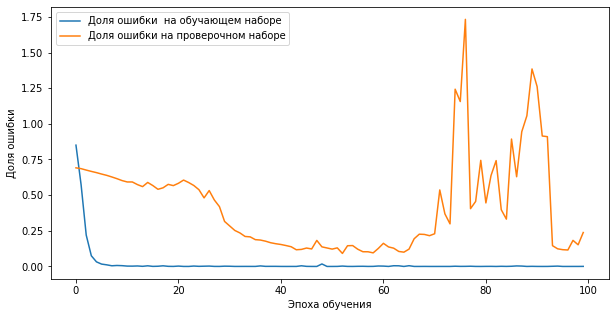

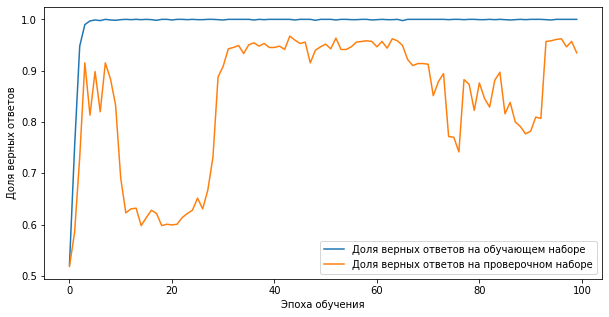

In [85]:
chart(history_model_LSTM_Conv1D)

### Средний процент и таблица

In [87]:
# Посмотрим на результат на тестовой выборке
val_model_LSTM_Conv1D, average_model_LSTM_Conv1D = recognizeMultiClass(model_LSTM_Conv1D, xTest6Classes, "model_LSTM_Conv1D")

Нейронная сеть:  model_LSTM_Conv1D

Юля  распознано  98 % сеть считает, что это  Юля ,  распознано ВЕРНО!
Елена  распознано  88 % сеть считает, что это  Елена ,  распознано ВЕРНО!

Средний процент распознавания  93 %


In [88]:
# C помощью функции получаем значения на последней эпохе
result_model_LSTM_Conv1D = table(history_model_LSTM_Conv1D)    

In [89]:
# Заносим результат в таблицу
df.loc['LSTM_Conv1D'] = [round(val_model_LSTM_Conv1D[0]*100, 2), round(val_model_LSTM_Conv1D[1]*100, 2), round(min(result_model_LSTM_Conv1D[0]),4), round(max(result_model_LSTM_Conv1D[1]*100), 2), round(min(result_model_LSTM_Conv1D[2]),2), round(max(result_model_LSTM_Conv1D[3]*100),2), average_model_LSTM_Conv1D]

# Общая сравнительная таблица

In [90]:
df

,Юля,Елена,learn_loss(min),learn_accuracy(max),val_loss(min),val_accuracy(max),Средний процент распознавания на проверочной выборке
Bow,98.99,94.85,0.0000,100.0,0.07,97.00,96.0
LSTM,96.73,91.33,0.0004,100.0,0.14,95.69,94.0
Conv_1D,32.75,100.00,0.0000,100.0,0.69,77.28,65.0
LSTM_Conv1D,98.24,88.35,0.0000,100.0,0.09,96.74,93.0


# Выводы:

1. Для того чтобы сравнивать возьмем нейронную сеть с **BOW** как основную и сеть, которая показала лучшие результаты.
2. В целом остальные подходы **CNN** и **RNN** показали хорошие результаты.
3. Как видно из таблицы нейронная сеть со сверточным слоем **Conv1D** показала худший результат. По грфику видно что сеть переобучилась и заучила все ответы на обучающую выборку, что плохо сказалось на тестовой. 
4. Видно что нейронные сети в предсказании двух авторов лучше справляются чем с шестью (из задания **Pro**)
5. Для более точного результата нужно производить как минимум **10** обучений нейронных сетей и смотреть средний результат.
6. Показатели можно улучшить если дообучать, используя меньший шаг(**learning rate**)
7. Изменяя архитектуру сети и гиперпараметры можно добиться лучшего результата и в целом любой подход в данной задаче **CNN** или **RNN** может быть оправдан.
8. При компеляции **loss** был изменен на **binary_crossentropy** для лучшего результата.
9. При обучении сети хорошо выводить графики и анализировать результат. 
10. Несмотря на относительно небольшую обучающую выборку, нейронные сети показали хороший результат. 
